In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import seaborn as sns

#### importing the X and y values from the Linear Regression notebook
>ensures both models work on the same values

In [2]:
X_train=pd.read_csv("data/X_train.csv",header=None).values.tolist()
y_train=pd.read_csv("data/y_train.csv",header=None).values.flatten().tolist()
X_test=pd.read_csv("data/X_test.csv",header=None).values.tolist()
y_test=pd.read_csv("data/y_test.csv",header=None).values.flatten().tolist()

#### importing the standard deviation of residuals from the Linear Regression notebook
> this will be used to decide the range of the values of delta, which we will search through to get the maximum R^2 metric

In [3]:
with open("sigma.txt", "r") as f:
    sigma = float(f.read())

## Robust Regression class

In [4]:
loss_history=[]
class RobustRegression:
    def __init__(self,X_train,delta):
        self.w=[random.uniform(-1,1) for _ in range(len(X_train[0]))]
        self.b=random.uniform(-1,1)
        self.delta=delta
        
    def loss_function(self,X_train,y_train):
        error=0
        for i in range(len(X_train)):
            y_pred=sum((wi*xi for wi,xi in zip(self.w,X_train[i])),self.b)
            y_tg=y_train[i]
            e_i=(y_pred-y_tg)
            if abs(e_i)<=self.delta:
                error+=0.5*(e_i)**2
            else:
                error+=self.delta*(abs(e_i)-(0.5*self.delta))
        MAE= error/len(X_train)
        return MAE

    def gradient_descent(self,X_train,y_train,alpha):
        w_grad=[0 for _ in range(len(self.w))]
        b_grad=0
        for i in range(len(X_train)):
            y_pred=sum((wi*xi for wi,xi in zip(self.w,X_train[i])),self.b)
            y_tg=y_train[i]
            e_i=(y_pred-y_tg)
            if e_i>self.delta:
                coeff=self.delta
            elif e_i<-self.delta:
                coeff=-self.delta
            else:
                coeff=e_i
            for j in range(len(self.w)):
                w_grad[j]+=coeff*X_train[i][j]
            b_grad+=coeff
        for k in range(len(self.w)):
            self.w[k]-=(1/len(X_train))*alpha*w_grad[k]
        self.b-=(1/len(X_train))*alpha*b_grad
        return f' w={self.w} , b={self.b}'

    def predict(self,X_test):
        prediction=[]
        for i in range(len(X_test)):
            prediction.append(sum((wi*xi for wi,xi in zip(self.w,X_test[i])),self.b))
        return prediction

    def R_squared(self,X_test,y_test):
        y_mean=sum(y_test)/len(y_test)
        TSS=sum([(y-y_mean)**2 for y in y_test])
        y_pred=[]
        for i in range(len(X_test)):
            y_pred.append(sum((wi*xi for wi,xi in zip(self.w,X_test[i])),self.b))
        RSS=sum([(y1-y2)**2 for y1,y2 in zip(y_pred,y_test)])
        return 1-(RSS/TSS) 

#### searching through a list of delta  values to get the value at which our R^2 metric is maximumm
 - Usually, the optimum value of delta lies between 1 *sigma and 2 *sigma (where sigma= standard deviation of residuals)
 - we are widening our range a bit for better accuracy

In [5]:
delta_list=np.arange(0.5*sigma,3*sigma,0.25)

def find_best_R_squared(delta_list):
    outputs=[]
    for i in range(len(delta_list)):
        model2=RobustRegression(X_train,delta_list[i])
        for _  in range(300):
            model2.gradient_descent(X_train,y_train,alpha=0.01)
        r2=model2.R_squared(X_test,y_test)
        outputs.append((delta_list[i],r2))
    best_delta,best_R2= max(outputs, key=lambda x: x[1])
    return float(best_delta),float(best_R2),outputs
    
outputs=find_best_R_squared(delta_list)[2]
best_delta=find_best_R_squared(delta_list)[0]

In [9]:
final_model=RobustRegression(X_train,best_delta)
epochs=1000
for _ in range(epochs):
    final_model.gradient_descent(X_train,y_train,alpha=0.01)

y_pred=[float(x) for x in final_model.predict(X_test)]

In [10]:
print(final_model.R_squared(X_test,y_test))

0.5460350360437118


#### plotting how the R^2 metric changes on changing delta

<Axes: >

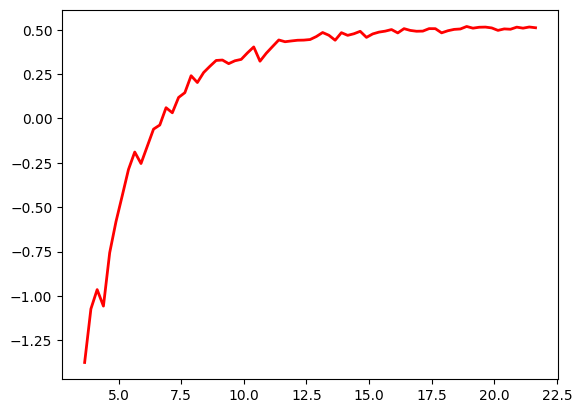

In [7]:
R2_values=[x[1] for x in outputs]
sns.lineplot(x=delta_list,y=R2_values,linewidth=2,color='red')

Text(0.5, 1.0, 'ROBUST REGRESSION MODEL')

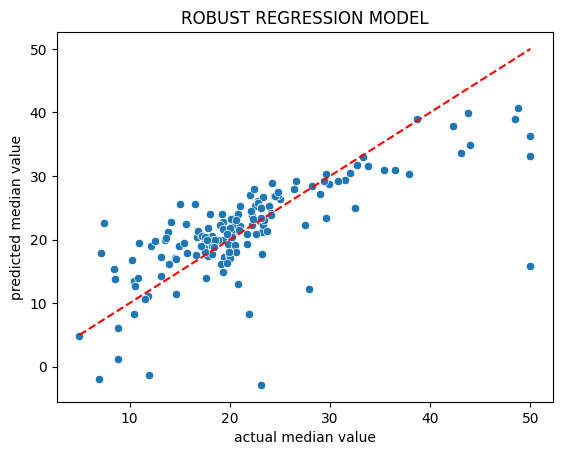

In [8]:
sns.scatterplot(x=y_test,y=y_pred)
sns.lineplot(x=y_test,y=y_test,linestyle='--',color='red')
plt.xlabel("actual median value")
plt.ylabel("predicted median value")
plt.title("ROBUST REGRESSION MODEL")